In [ ]:
# Questions
# 1. How do we avoid NaN in the output from Encoder?
# 2. Is loss function correct? 
#    - How do we avoid normal distributed reconstructionS?
# 3. Do KL divergence only work under the assumption that covariance is diagonal?


In [1]:
! pip install pandas
! pip install pydicom
! pip install seaborn

import glob, pylab, pandas as pd
import pydicom, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from skimage.transform import resize
from skimage.exposure import equalize_hist


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

import torch
cuda = torch.cuda.is_available()

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

import torch.nn as nn
from torch.nn.functional import softplus
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d, ReLU, ELU
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, dropout, dropout2d
import time


You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 7.3MB 221kB/s ta 0:00:011
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# Show files in data
#!ls data

# display label format
#df = pd.read_csv('../input/stage_2_train_labels.csv')
df = pd.read_csv('data/stage_1_train_labels.csv')


# Parameters
batch_size = 32
No_train_samples = 4096
No_test_samples = 2048
No = 4
patientId = df['patientId'][No]
#dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId
dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
#print(df.iloc[No])


IMG_SIZE = 224
img_dimension = [IMG_SIZE,IMG_SIZE] # New size of xray images. 
unq, idx = np.unique(df['patientId'], return_index = True) # Get only unique entrances from the provided data (some patients occur multiple times)

# Reshape images and match to corresponding label in new dataframe
Target = []
Image = []
Do_img_eq = True

print_every = 100

elapsed_time = 0
tic = time.clock()
for i in range(0,No_train_samples):
    Target.append(df.Target[idx[i]]) # Get label  
    patientId = df['patientId'][idx[i]] # Get patient id from the idx 
    #dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect'))#, anti_aliasing=True)) # resize image
    if Do_img_eq:
        Image[-1] = equalize_hist(Image[-1])
        """
        if i % 2:
            im = Image[-1]
            im[0:224,0:112] = 1
            Image[-1] = im
        if (i+1) % 2:
            im = Image[-1]
            im[0:224,112:224] = 0
            Image[-1] = im
        """
    # Logging: counting and time remaining
    if not i % 100:
        toc = time.clock()
        period_time = toc - tic;
        if not i == 0:
            elapsed_time = (elapsed_time + period_time)
            mean_period_time = elapsed_time// ((i)//print_every)
            minutes = round(mean_period_time*( (No_train_samples-i)//print_every)//60)
            seconds = round(mean_period_time*( (No_train_samples-i)//print_every)%60)
            print("Data loaded:", i,"/",No_train_samples,  "    Remaining time: ", minutes,":", seconds)
        tic = time.clock();   
print("Train data loaded:", i+1)

# Convert to Tensor
Target = torch.Tensor(Target)
Image = torch.Tensor(Image)
Image = Image.unsqueeze(1)

# Construct DataLoader
loader = TensorDataset(Image, Target)
train_loader = DataLoader(loader, batch_size=batch_size, shuffle = True)
print(' ')
        
Target = []
Image = []
tic = time.clock()
elapsed_time = 0
for i in range(0,No_test_samples):
    Target.append(df.Target[idx[No_train_samples+i]]) # Get label  
    patientId = df['patientId'][idx[No_train_samples+i]] # Get patient id from the idx 
    #dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect'))#, anti_aliasing=True)) # resize image
    if Do_img_eq:
        Image[-1] = equalize_hist(Image[-1])
        """
        if i % 2:
            im = Image[-1]
            im[0:224,0:112] = 1
            Image[-1] = im
        if (i+1) % 2:
            im = Image[-1]
            im[0:224,112:224] = 0
            Image[-1] = im
        """
    # Logging: counting and time remaining
    if not i % print_every:
        toc = time.clock()
        period_time = toc - tic;
        if not i == 0:
            elapsed_time = (elapsed_time + period_time)
            mean_period_time = elapsed_time// ((i)//print_every)
            minutes = round(mean_period_time*( (No_test_samples-i)//print_every)//60)
            seconds = round(mean_period_time*( (No_test_samples-i)//print_every)%60)
            print("Data loaded:", i, "/",No_test_samples,"    Remaining time: ", minutes,":", seconds)
        tic = time.clock();

print("Test data loaded:", i+1)

# Convert to Tensor
Target = torch.Tensor(Target)
Image = torch.Tensor(Image)
Image = Image.unsqueeze(1)
#print(Image.shape)

# Construct DataLoader
loader = TensorDataset(Image, Target)
test_loader = DataLoader(loader, batch_size=batch_size, shuffle = True)
print(' ')



/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Data loaded: 100 / 4096     Remaining time:  0 : 39
Data loaded: 200 / 4096     Remaining time:  0 : 38
Data loaded: 300 / 4096     Remaining time:  0 : 37
Data loaded: 400 / 4096     Remaining time:  0 : 36
Data loaded: 500 / 4096     Remaining time:  0 : 35
Data loaded: 600 / 4096     Remaining time:  0 : 34
Data loaded: 700 / 4096     Remaining time:  0 : 33
Data loaded: 800 / 4096     Remaining time:  0 : 32
Data loaded: 900 / 4096     Remaining time:  0 : 31
Data loaded: 1000 / 4096     Remaining time:  0 : 30
Data loaded: 1100 / 4096     Remaining time:  0 : 29
Data loaded: 1200 / 4096     Remaining time:  0 : 28
Data loaded: 1300 / 4096     Remaining time:  0 : 27
Data loaded: 1400 / 4096     Remaining time:  0 : 26
Data loaded: 1500 / 4096     Remaining time:  0 : 25
Data loaded: 1600 / 4096     Remaining time:  0 : 24
Data loaded: 1700 / 4096     Remaining time:  0 : 23
Data loaded: 1800 / 4096     Remaining time:  0 : 22
Data loaded: 1900 / 4096     Remaining time:  0 : 21
Da

(-0.5, 223.5, 223.5, -0.5)

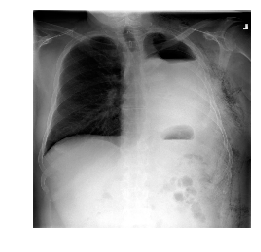

In [4]:
# Show an example image 
im = Image[5]
im = im.squeeze(0)
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
# Histogram Equalization
"""
from IPython.display import Image
from skimage import exposure
import pylab

Image = []
row_int = []

for i in range(0,16):
    patientId = df['patientId'][idx[i]] # Get patient id from the idx 
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect', anti_aliasing=True)) # resize image
    tmp = equalize_hist(Image[-1])
    row_int.append(np.mean(tmp[:,40:180],axis=1))

# Plotting of images
f, axarr = plt.subplots(1, 1, figsize=(50, 25))

columns = 10
canvas = np.zeros((columns*IMG_SIZE, IMG_SIZE*3))
for j in range(columns):
    canvas[j*IMG_SIZE:(j+1)*IMG_SIZE , 0:IMG_SIZE] = Image[j]
    canvas[j*IMG_SIZE:(j+1)*IMG_SIZE , IMG_SIZE:2*IMG_SIZE] = equalize_hist(Image[j])
    canvas[j*IMG_SIZE:(j+1)*IMG_SIZE , 2*IMG_SIZE:3*IMG_SIZE] = np.matrix.transpose(np.tile(row_int[j],(IMG_SIZE,1)))

plt.imshow(canvas, cmap='gray')
ax = axarr
ax.set_title('Original Images')
ax.axis('off')
ax.grid(False)
"""

In [30]:
# Define size variables
height = IMG_SIZE
width = IMG_SIZE
channels = 1
num_features = 224**2

# Regulization
L2_reg = 1e-6

# Conv Layers
conv_out_channels = [8, 16, 32, 64]
conv_kernel = [15, 11, 5, 5]
conv_padding = [7, 5, 2, 2]
conv_stride = [2, 2, 1, 1]

# MaxPool Layers
pool_kernel = 4
pool_padding = 2
pool_stride = 2


    # Calculating the dimensions
def compute_conv_dim(height, width, kernel_size, padding_size, stride_size):
    height_new = int((height - kernel_size + 2 * padding_size) / stride_size + 1)
    width_new =  int((width  - kernel_size + 2 * padding_size) / stride_size + 1)
    return [height_new, width_new]

def compute_final_dimension(height, width, last_num_channels, num_layers):
    # First conv layer
    CNN_height = height
    CNN_width = width
    for i in range(num_layers):
        # conv layer
        CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width, conv_kernel[i], conv_padding[i], conv_stride[i])
        # maxpool layer
        CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width, pool_kernel, pool_padding, pool_stride)
    final_dim = CNN_height * CNN_width * last_num_channels
    return final_dim
    
######## Image has to be: (num, channels, height, width)!!!! #########
class CNN_VAE(nn.Module):
 
    def __init__(self, latent_features, num_samples):
        super(CNN_VAE, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        
        # Calculate final size of the CNN
        self.final_dim = compute_final_dimension(height,width,conv_out_channels[-1],4)
        print(self.final_dim)
        ## CNN encoder
        self.encoder = nn.Sequential(            
                Conv2d(     in_channels=channels,
                            out_channels=conv_out_channels[0],
                            kernel_size=conv_kernel[0],
                            stride=conv_stride[0],
                            padding=conv_padding[0]),
            
                MaxPool2d(  kernel_size=pool_kernel, 
                            stride=pool_stride,
                            padding=pool_padding),
                ReLU(),
                BatchNorm2d(conv_out_channels[0]),
                Dropout2d(p=0.2),
            
                Conv2d(     in_channels=conv_out_channels[0],
                            out_channels=conv_out_channels[1],
                            kernel_size=conv_kernel[1],
                            stride=conv_stride[1],
                            padding=conv_padding[1]),
            
                MaxPool2d(  kernel_size=pool_kernel, 
                            stride=pool_stride,
                            padding=pool_padding),
                ReLU(),
                BatchNorm2d(conv_out_channels[1]),
                Dropout2d(p=0.2),
            
                Conv2d(     in_channels=conv_out_channels[1],
                            out_channels=conv_out_channels[2],
                            kernel_size=conv_kernel[2],
                            stride=conv_stride[2],
                            padding=conv_padding[2]),
            
                MaxPool2d(  kernel_size=pool_kernel, 
                            stride=pool_stride,
                            padding=pool_padding),
                ReLU(),
                BatchNorm2d(conv_out_channels[2]),
                Dropout2d(p=0.2),
                
                Conv2d(     in_channels=conv_out_channels[2],
                            out_channels=conv_out_channels[3],
                            kernel_size=conv_kernel[3],
                            stride=conv_stride[3],
                            padding=conv_padding[3]),
            
                MaxPool2d(  kernel_size=pool_kernel, 
                            stride=pool_stride,
                            padding=pool_padding),
                ReLU(),
                BatchNorm2d(conv_out_channels[3]),
                Dropout2d(p=0.2),

        )
        
        self.CNN_to_latent = Linear(in_features=self.final_dim, out_features=self.latent_features*2)
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            Linear(in_features=self.latent_features, out_features=128),
            #BatchNorm1d(num_features=128, eps=1e-3),
            ELU(),
            Linear(in_features=128, out_features=256),
            #BatchNorm1d(num_features=256),
            ELU(),
            Linear(in_features=256, out_features=num_features*2)
        )
        

    def forward(self, x): 
        outputs = {}

        x = self.encoder(x)
        if torch.sum(torch.isnan(x))>0:
            print('output from encoder is NaN')
            print(torch.sum(torch.isnan(x)))

        batch_size = x.size(0)
        x = x.view( batch_size, -1)
        # x = x.view(num_samples,-1) # fold out the CNN layers
        x = self.CNN_to_latent(x)
        if torch.sum(torch.isnan(x))>0:
            print("After fully connected layer:")
            print(torch.sum(torch.isnan(x)))

        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(x, 2, dim=-1)

        # Make sure that the log variance is positive
        log_var = softplus(log_var)

        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)

            if cuda:
                epsilon = epsilon.cuda()

        sigma = torch.exp(log_var/2)

        # We will need to unsqueeze to turn (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1) 
        if torch.sum(torch.isnan(z))>0:
            print("z:")
            print(torch.sum(torch.isnan(z)))

        # Run through decoder
        x = self.decoder(z)
        if torch.sum(torch.isnan(x))>0:
            print("After decoder:")
            print(torch.sum(torch.isnan(x)))

        x_mean, x_log_var = torch.chunk(x, 2, dim=-1) # the mean and log_var reconstructions from the decoder

        # The original digits are on the scale [0, 1]
        x_hat = torch.sigmoid(x_mean) # to scale for showing an image
        x_log_var = softplus(x_log_var)

        # Mean over samples
        x_hat = torch.mean(x_hat, dim=1)
        x_log_var= torch.mean(x_log_var, dim=1)

        # Resize x_hat from [batch_size, no_features] to [batch_size, channels, height, width]
        x_hat = x_hat.view( batch_size, 1, height, width)
        x_log_var = x_log_var.view( batch_size, 1, height, width)

        outputs["x_hat"] = x_hat # This is used for visulizations only 
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var

        # image recontructions (notice they are outputted as matrices)
        outputs["x_mean"] = x_hat #torch.reshape(x_mean,(-1,height,width)) # mean reconstructions (for loss!!!)
        outputs["x_log_var"] = x_log_var #torch.reshape(x_log_var,(-1,height,width)) # log var reconstructions (for loss!!!)

        return outputs




# Parameters
latent_features = 4
num_samples = 10

net = CNN_VAE(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

1600
CNN_VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(15, 15), stride=(2, 2), padding=(7, 7))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=2, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2)
    (5): Conv2d(8, 16, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
    (6): MaxPool2d(kernel_size=4, stride=2, padding=2, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2)
    (10): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): MaxPool2d(kernel_size=4, stride=2, padding=2, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2)
    (15): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (16): 

In [31]:
from torch.nn.functional import binary_cross_entropy
from torch import optim
import math

def Gaussian_density(sample_img,mu_img,log_var_img):
    c = - 0.5 * math.log(2 * math.pi)
    density = c - log_var_img/2 - (sample_img - mu_img)**2/(2 * torch.exp(log_var_img))
    #print("Density:",density)
    #print("Density.shape:", density.shape)
    return torch.sum(density,dim = 1) # Sum over channels

def ELBO_loss(sample_img, mu_img, log_var_img, mu, log_var):
    
    # Reconstruction error, log[p(x|z)]
    # Sum over features
        # Old code
        #likelihood = -binary_cross_entropy(y, t, reduction="none")
        #likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # New code with guassian density
    likelihood = Gaussian_density(sample_img, mu_img, log_var_img)
    #likelihood = -binary_cross_entropy(mu_img,sample_img, reduction="none")
    #ikelihood = likelihood.view(likelihood.size(0), -1).sum(1)
    
    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    #print("mu.shape", mu.shape)
    #print("kl.shape:", kl.shape)
    #print("Likelihood shape:", likelihood.shape)
    tmp = likelihood.view(batch_size, -1)
    tmp = torch.sum(tmp, dim=1) # Sum over features (224x224 = 50.176)
    #print("Likelihood sum shape:", tmp.shape)
    #print("kl.mean shape:", kl.shape)
    
    ELBO = torch.mean(tmp) - torch.mean(kl)

    # Notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# Define optimizer: The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay= 1e-4)
loss_function = ELBO_loss

In [32]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))
x = Variable(x)
if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
mu_img, log_var_img = outputs["x_mean"], outputs["x_log_var"]
z = outputs["z"]
"""
print(torch.sum(torch.isnan(mu_img)))
print(torch.sum(torch.isnan(log_var_img)))
print(torch.sum(torch.isnan(x)))
print(torch.sum(torch.isnan(x_hat)))
print(outputs["mu"])
print(outputs["log_var"])
print(net.CNN_to_latent.weight)
"""
print(mu_img.shape)
print(log_var_img.shape)


loss, kl = loss_function(x, mu_img, log_var_img, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 10, 4])
tensor(64682.9336, grad_fn=<NegBackward>)
tensor(32.7737, grad_fn=<SumBackward0>)


In [33]:
# Deleting variable Image and reload package Image
%reset_selective -f "^Image$"
from IPython.display import Image
from sklearn.manifold import TSNE


import os
from sklearn.decomposition import PCA


num_epochs = 50 # No_train_samples // batch_size
########################################################################################################################################################################
batch_per_epoch = No_train_samples // batch_size
########################################################################################################################################################################
tmp_img = "tmp_vae_out.png"
show_sampling_points = False
classes = [0,1]

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)


for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    count = 0
    for x, y in train_loader:
        x = Variable(x)
        count = count + 1
        if not count % (batch_per_epoch/4):
            print("Epoch:", epoch, "Batch:", count,"/",batch_per_epoch)
        
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        mu_img, log_var_img = outputs["x_mean"], outputs["x_log_var"]

        # elbo, kl = loss_function(x_hat, x, mu, log_var)
        elbo, kl = loss_function(x, mu_img, log_var_img, mu, log_var)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = Variable(x)
        
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        mu_img, log_var_img = outputs["x_mean"], outputs["x_log_var"]
        z = outputs["z"]
    
        # elbo, kl = loss_function(x_hat, x, mu, log_var)
        elbo, kl = loss_function(x, mu_img, log_var_img, mu, log_var)
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch == 0:
        continue
    
    # -- Plotting --
    f, axarr = plt.subplots(4, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    if batch_size > 4:
        rows = 4
        columns = batch_size // rows
    else:
        rows = 2
        columns = 2
        
        
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions

    """ PCA """
    #z = PCA(n_components=2).fit_transform(z.reshape(-1,latent_features))
    #z = z.reshape(batch_size,num_samples,2)
    
    """ TSNE """
    z = TSNE(n_components=2).fit_transform(z.reshape(-1,latent_features))
    z = z.reshape(batch_size,num_samples,2)
    
    
#     print(z.shape)
#     print(z.reshape(-1,latent_features).shape)
    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
#         epsilon = torch.from_numpy(grid).float().to(device)
        epsilon = torch.randn(batch_size, latent_features).to(device)
        samples = torch.sigmoid(net.decoder(epsilon)).detach()

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = samples[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = samples[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = x[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions: mean')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x_hat[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = x_hat[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[3, 0]
    ax.set_title('Reconstructions: sigma')
    ax.axis('off')

    sigma = torch.exp(log_var_img/2)
    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x_hat[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = sigma[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')
    
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    #clear_output(wait=True)

    os.remove(tmp_img)

Using device: cpu
Epoch: 0 Batch: 32 / 128
Epoch: 0 Batch: 64 / 128


KeyboardInterrupt: 